Đang chạy trên: cuda:0
Đã tải 30 nhãn: ['Brad_Pitt', 'Conor_McGregor', 'David_Beckham', 'Erling_Haaland', 'Huy', 'J97', 'Jeff_Bezo', 'Jeffray', 'Joji', 'Khabib', 'Leonardo_DiCaprio', 'Levi', 'Messi', 'Mixigaming', 'Oii', 'Park_Hang_seo', 'Robert_Downey_Junior', 'Ronaldo', 'SonTungMTP', 'Taylor_Swift', 'Tobey_Maguire', 'Tom Hanks', 'Tom_Cruise', 'Vo_Nguyen_Giap', 'Will_Smith', 'Zhao_Lusi', 'antony', 'charles_leclerc', 'faker', 'thayongnoi']
-> Load model thành công!


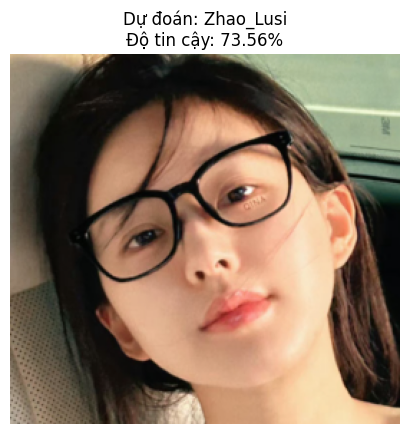

('Zhao_Lusi', 73.55993390083313)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# 1. Kết nối Google Drive
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# ================= CẤU HÌNH =================
MODEL_PATH = '/content/drive/MyDrive/DeepLearning/face_recognition_squeezenet_split.pth'
DATA_DIR = '/content/drive/MyDrive/DeepLearning/data' # Dùng để lấy tên nhãn (Tên 30 người)
TEST_IMAGE_PATH = '/content/drive/MyDrive/DeepLearning/anh2.png' # <--- Thay ảnh bạn muốn test vào đây
# ============================================

# 2. Thiết bị (GPU hoặc CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Đang chạy trên: {device}")

# 3. Lấy lại danh sách nhãn (Class Names)
# Vì file .pth không lưu tên nhãn, ta cần đọc lại từ thư mục train
try:
    class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
    print(f"Đã tải {len(class_names)} nhãn: {class_names}")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy thư mục data để lấy tên nhãn. Bạn cần tự định nghĩa list class_names.")
    # Ví dụ: class_names = ['Nguoi_A', 'Nguoi_B', ...]

# 4. Khởi tạo lại kiến trúc mạng (Giống hệt lúc train)
# Lưu ý: weights=None vì ta sẽ load weight của riêng ta
model = models.squeezenet1_1(weights=None)

# Sửa lại lớp cuối cùng cho khớp với 30 nhãn
model.classifier[1] = nn.Conv2d(512, len(class_names), kernel_size=(1,1))

# 5. Load trọng số từ file .pth vào model
try:
    # map_location giúp load được kể cả khi bạn train bằng GPU nhưng giờ chạy bằng CPU
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model = model.to(device)
    model.eval() # QUAN TRỌNG: Khóa các lớp Dropout/Batchnorm để dự đoán chính xác
    print("-> Load model thành công!")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file model tại {MODEL_PATH}")

# 6. Hàm xử lý và dự đoán
def predict_image(image_path):
    # Transform chuẩn cho SqueezeNet (giống lúc train)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        # Mở ảnh
        img_raw = Image.open(image_path).convert('RGB')

        # Tiền xử lý
        img_tensor = transform(img_raw).unsqueeze(0) # Thêm chiều batch -> [1, 3, 224, 224]
        img_tensor = img_tensor.to(device)

        # Dự đoán
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidence, idx = torch.max(probs, 1)

        label = class_names[idx.item()]
        score = confidence.item() * 100

        # Hiển thị
        plt.imshow(img_raw)
        plt.axis('off')

        plt.title(f"Dự đoán: {label}\nĐộ tin cậy: {score:.2f}%")
        plt.show()

        return label, score

    except Exception as e:
        print(f"Có lỗi khi đọc ảnh: {e}")

# --- CHẠY THỬ ---
predict_image(TEST_IMAGE_PATH)

In [ ]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 